In [1]:
from Models.NilmCnn1D import CNN_1D
from Data.data_processing import normalize, prepare_s2p_data
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
house2 = pd.read_csv("Data/CLEAN_House2.csv", nrows=2000000)

In [3]:
sequence_length = 199

house2_normalized , scalers = normalize(house2, ["Aggregate", "Appliance3"])
house2_normalized.describe()

,Aggregate,Appliance3
count,2.000000e+06,2.000000e+06
mean,1.562324e-02,2.364343e-02
std,4.183696e-02,1.393229e-01
min,0.000000e+00,0.000000e+00
25%,3.659280e-03,0.000000e+00
50%,6.342753e-03,0.000000e+00
75%,9.188860e-03,0.000000e+00
max,1.000000e+00,1.000000e+00


In [4]:
X, y = prepare_s2p_data(
    house2_normalized['Aggregate'],
    house2_normalized['Appliance3'],
    sequence_length,
    stride= 10
)

X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False, test_size=0.2)

X_train = X_train[..., np.newaxis]  
X_test  = X_test[..., np.newaxis]

print(X_train.shape)

(159984, 199, 1)


In [5]:
model_former = CNN_1D

model = model_former.build_s2p_model(window_len=sequence_length)

early_stop = EarlyStopping(monitor='val_loss', patience = 5, min_delta=1e-4, restore_best_weights=True)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test,y_test], callbacks=[early_stop])

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 232s 46ms/step - loss: 0.0201 - mae: 0.0450 - val_loss: 0.0194 - val_mae: 0.0464
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 227s 45ms/step - loss: 0.0202 - mae: 0.0455 - val_loss: 0.0194 - val_mae: 0.0399
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 409s 82ms/step - loss: 0.0191 - mae: 0.0430 - val_loss: 0.0194 - val_mae: 0.0468
Epoch 4/100
1161/5000 ━━━━━━━━━━━━━━━━━━━━ 5:39 88ms/step - loss: 0.0183 - mae: 0.0422

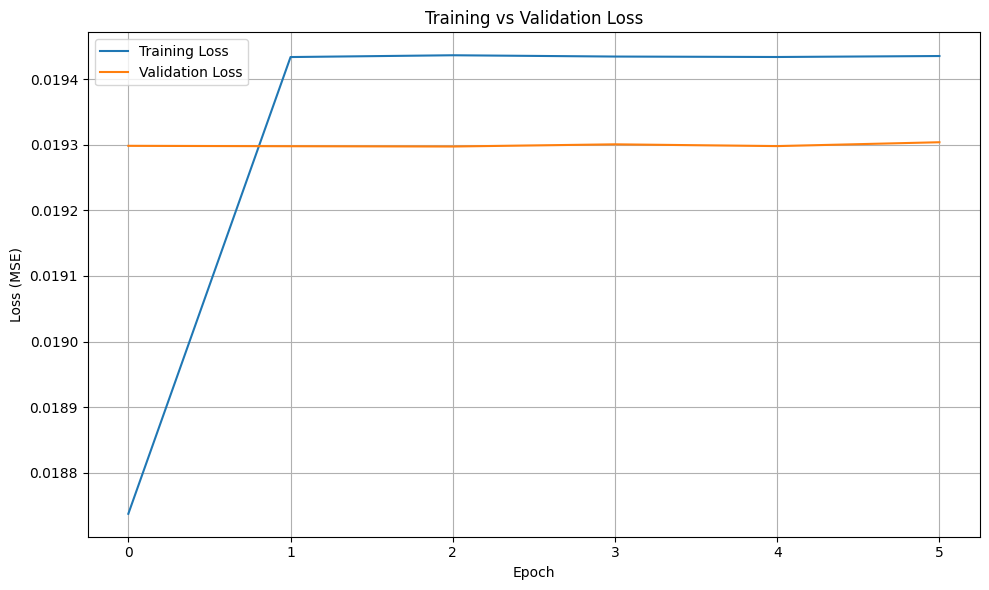

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step


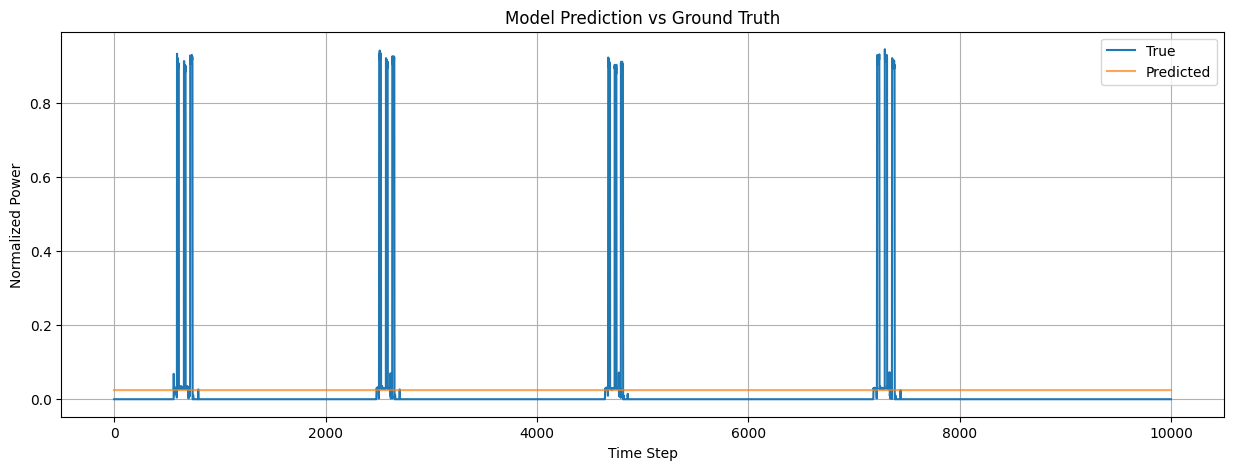

In [ ]:
start_index = 0
num_points = 10000

end_index = start_index + num_points
x = range(start_index, start_index + len(y_true[start_index:end_index]))

plt.figure(figsize=(15, 5))
plt.plot(x, y_true[start_index:end_index], label='True')
plt.plot(x, y_pred[start_index:end_index], label='Predicted', alpha=0.7)
plt.title("Model Prediction vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Normalized Power")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mae_norm = mean_absolute_error(y_true, y_pred)
print(f"MAE (normalized units): {mae_norm:.4f}")


agg_scaler = scalers["Aggregate"]          # the scaler you used for Aggregate
y_pred_watts = agg_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_watts = agg_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

mae_watts = mean_absolute_error(y_true_watts, y_pred_watts)
print(f"MAE (real scale): {mae_watts:.2f} W")

MAE (normalized units): 0.0444
MAE (real scale): 1091.46 W
